In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Total Sales 2000-2021.csv')
df

,Period,Total_Sales
0,2000-01-01,1517
1,2000-04-01,1248
2,2000-07-01,1677
3,2000-10-01,1393
4,2001-01-01,1558
...,...,...
83,2020-10-01,5142
84,2021-01-01,5268
85,2021-04-01,5077
86,2021-07-01,5752


In [3]:
display(df.isnull().sum(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Period       88 non-null     object
 1   Total_Sales  88 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


Period         0
Total_Sales    0
dtype: int64

None

In [4]:
df['Period'] = pd.to_datetime(df['Period'])
df.set_index('Period', inplace=True)
df

,Total_Sales
Period,
2000-01-01,1517
2000-04-01,1248
2000-07-01,1677
2000-10-01,1393
2001-01-01,1558
...,...
2020-10-01,5142
2021-01-01,5268
2021-04-01,5077


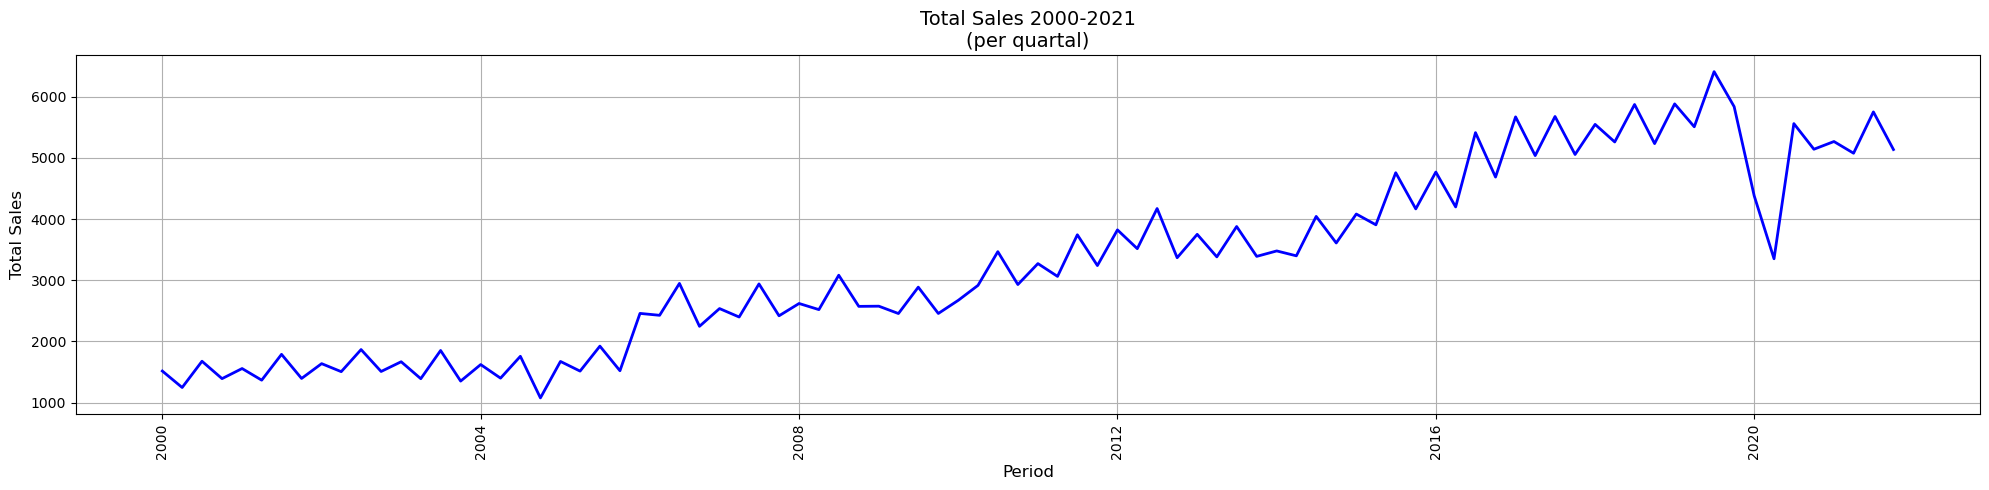

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(df['Total_Sales'], color='blue', linestyle='-', linewidth=2)
plt.title('Total Sales 2000-2021\n(per quartal)', fontsize=14)
plt.xlabel('Period', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

# Train-Test Split

In [6]:
# Train-Test split (80:20)

train_size = int(len(df) * 0.7)
train = df.iloc[:train_size]    # 70% training data
test  = df.iloc[train_size:]    # 30% testing data

print('Train Data:', train.shape)
print('Test Data:', test.shape)

Train Data: (61, 1)
Test Data: (27, 1)


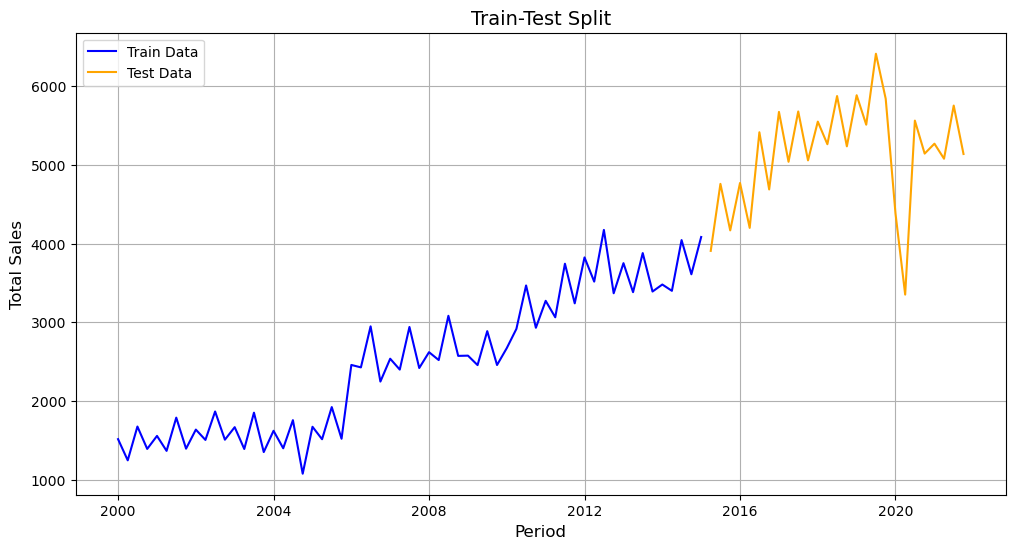

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Total_Sales'], label='Train Data', color='blue')
plt.plot(test.index, test['Total_Sales'], label='Test Data', color='orange')
plt.title('Train-Test Split', fontsize=14)
plt.xlabel('Period', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.legend()
plt.grid()
plt.show()

# Stationarity Test (ADF)

In [8]:
# Perform ADF test on the training data
adf_result = adfuller(train['Total_Sales'])

# Display ADF test results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Check if differencing is needed
if adf_result[1] > 0.05:
    print("Data is not stationary. Differencing is required.")
else:
    print("Data is stationary. No differencing needed.")


ADF Statistic: 0.1224487068914609
p-value: 0.9675607691991901
Critical Values:
   1%: -3.55770911573439
   5%: -2.9167703434435808
   10%: -2.59622219478738
Data is not stationary. Differencing is required.


In [9]:
# Perform first-order differencing
train_diff = train['Total_Sales'].diff().dropna()

# ADF test on differenced data
adf_diff_result = adfuller(train_diff)

# Display results
print('ADF Statistic (Differenced):', adf_diff_result[0])
print('p-value (Differenced):', adf_diff_result[1])
if adf_diff_result[1] > 0.05:
    print("Further differencing may be needed.")
else:
    print("Data is stationary after differencing.")

ADF Statistic (Differenced): -3.470026905147993
p-value (Differenced): 0.008791071452828333
Data is stationary after differencing.


# SARIMA

In [10]:
# ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from pmdarima import auto_arima                        
from pmdarima.model_selection import train_test_split

from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
import itertools

In [11]:
# Find best ARIMA using auto_arima
model_autoarima = auto_arima(train['Total_Sales'], seasonal=True, m=4, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=811.880, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=764.021, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=783.191, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=825.621, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=766.124, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[4] intercept   : AIC=764.014, Time=0.13 sec
 ARIMA(1,0,0)(2,1,1)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(2,1,0)[4] intercept   : AIC=811.855, Time=0.11 sec
 ARIMA(2,0,0)(2,1,0)[4] intercept   : AIC=764.258, Time=0.19 sec
 ARIMA(1,0,1)(2,1,0)[4] intercept   : AIC=765.208, Time=0.18 sec
 ARIMA(0,0,1)(2,1,0)[4] intercept   : AIC=781.462, Time=0.14 sec
 ARIMA(2,0,1)(2,1,0)[4] intercept   : AIC=762.050, Time=0.27 sec
 ARIMA(2,0,1)(1,1,0)[4] intercept   : AIC=767.978, Time=0.1

In [12]:
sarima_model = SARIMAX(
    train_diff,                     # Already using the data after manual differencing -> so, in order d=0
    order=(2, 0, 2),
    seasonal_order=(2, 1, 1, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

In [13]:
sarima_model.aic

619.1136119368972

In [14]:
# SARIMA Forecast
forecast_diff = sarima_model.forecast(steps=len(test))

# Inverse differencing (restore original scale)
forecast_sarima = forecast_diff.cumsum() + train['Total_Sales'].iloc[-1]

In [15]:
# Evaluate SARIMA to test data

mse_sarima = mean_squared_error(test['Total_Sales'], forecast_sarima)
rmse_sarima = np.sqrt(mse_sarima)
print(f'SARIMA MSE  : {mse_sarima:.2f}\nSARIMA RMSE : {rmse_sarima:.2f}')

SARIMA MSE  : 393373.86
SARIMA RMSE : 627.20


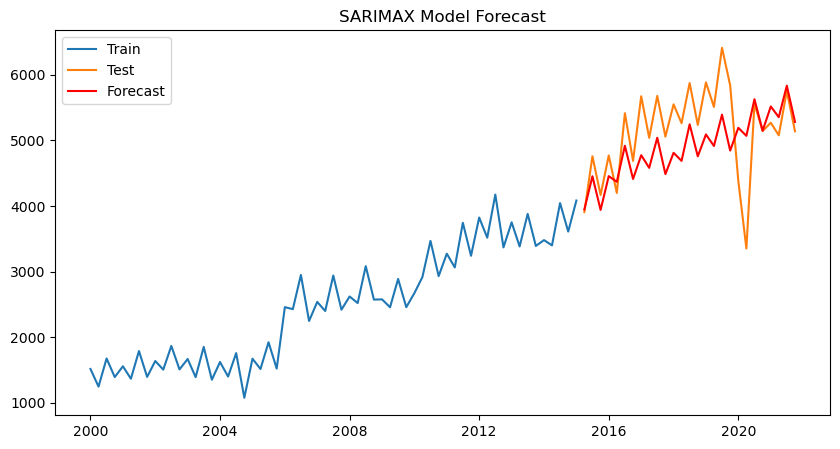

In [16]:
import matplotlib.pyplot as plt

# Data train, test and forecast visualization
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_sarima, label='Forecast', color='red')
plt.legend()
plt.title('SARIMAX Model Forecast')
plt.show()

# PROPHET

In [17]:
#pip install prophet

In [18]:
from prophet import Prophet

In [19]:
prophet_df = df.copy().reset_index().rename(columns={'Period': 'ds', 'Total_Sales': 'y'})
prophet_df

,ds,y
0,2000-01-01,1517
1,2000-04-01,1248
2,2000-07-01,1677
3,2000-10-01,1393
4,2001-01-01,1558
...,...,...
83,2020-10-01,5142
84,2021-01-01,5268
85,2021-04-01,5077
86,2021-07-01,5752


In [20]:
# Split train-test (70:30)
split_date = prophet_df['ds'].quantile(0.7)

train_pro  = prophet_df[prophet_df['ds'] <= split_date].copy()
test_pro   = prophet_df[prophet_df['ds'] > split_date].copy()

In [21]:
# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(train_pro)

20:31:11 - cmdstanpy - INFO - Chain [1] start processing
20:31:12 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# Prophet Forecast
periods_to_forecast = len(test)  # Berapa periode yang perlu kita prediksi
future = prophet_model.make_future_dataframe(periods=periods_to_forecast, freq='Q')

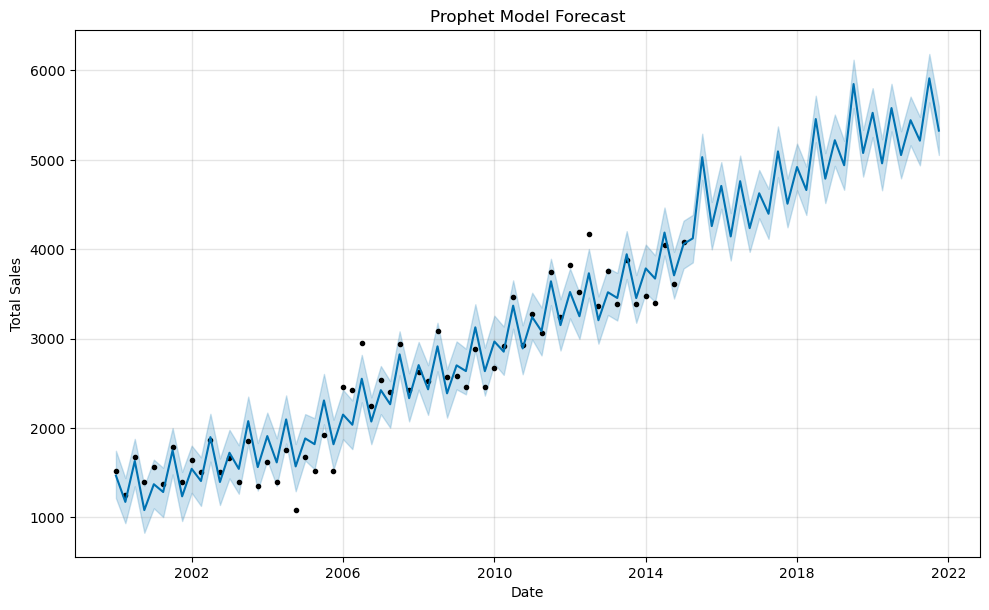

In [23]:
forecast_prophet = prophet_model.predict(future)
fig = prophet_model.plot(forecast_prophet)

ax = fig.gca()
ax.set_title("Prophet Model Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Total Sales")
plt.show()

In [24]:
# Extract predictions and actual values (test data)
predictions = forecast_prophet['yhat'][len(train_pro):]
actual_values = test_pro['y']

In [25]:
# Evaluate Prophet performance
mse_pro  = mean_squared_error(actual_values, predictions)
rmse_pro = np.sqrt(mse_pro)
print(f'Prophet MSE  : {mse_pro:.2f}\nProphet RMSE : {rmse_pro:.2f}')

Prophet MSE  : 359920.67
Prophet RMSE : 599.93


---

# SUMMARY

In [26]:
results = pd.DataFrame({
    'Model' : ['SARIMA', 'Prophet'],
    'MSE'   : [mse_sarima, mse_pro],
    'RMSE'  : [rmse_sarima, rmse_pro]
})

results

,Model,MSE,RMSE
0,SARIMA,393373.859423,627.195232
1,Prophet,359920.666005,599.933885
